In [1]:
# Core
import re, os, sys, string
import pandas as pd
from pathlib import Path
import numpy as np
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
from matplotlib import colors as mcolors
# Working with trees
from ete3 import Tree, TreeStyle, TextFace, NodeStyle, faces
import toytree
# Stats
import scipy.stats as stats

Following Matt Johnson's [Phyparts Pie Charts notebook](https://github.com/mossmatters/MJPythonNotebooks/blob/master/PhyParts_PieCharts.ipynb). First grab all of the relevant files.

# Final concordance analysis

In [2]:
treesDir = Path("../Data/Concordance_analysis/Trees/")
exon_gts = treesDir / "dna.genetrees.rooted.trees"
supercontig_gts = treesDir / "supercontig.genetrees.rooted.trees"
exon_st = treesDir / "dna_collapsed33.rooted.new"
supercontig_st = treesDir / "supercontig_collapsed33.rooted.new"

## Creating pie chart plots
`SC` and `EX` prefixes refer to supercontig (exon+flanking) and exon-only datasets, respectively.

In [3]:
phyparts_dir = Path("../Data/Concordance_analysis/phyparts/")
supercontig_dir = phyparts_dir / "Supercontig"
exon_dir = phyparts_dir / "Exon-only"

SCkeyfile = next(supercontig_dir.glob("*.key"))
SChistfile = next(supercontig_dir.glob("*.hist"))
SCconconfile = next(supercontig_dir.glob("*.concon.*"))

EXkeyfile = next(exon_dir.glob("*.key"))
EXhistfile = next(exon_dir.glob("*.hist"))
EXconconfile = next(exon_dir.glob("*.concon.*"))

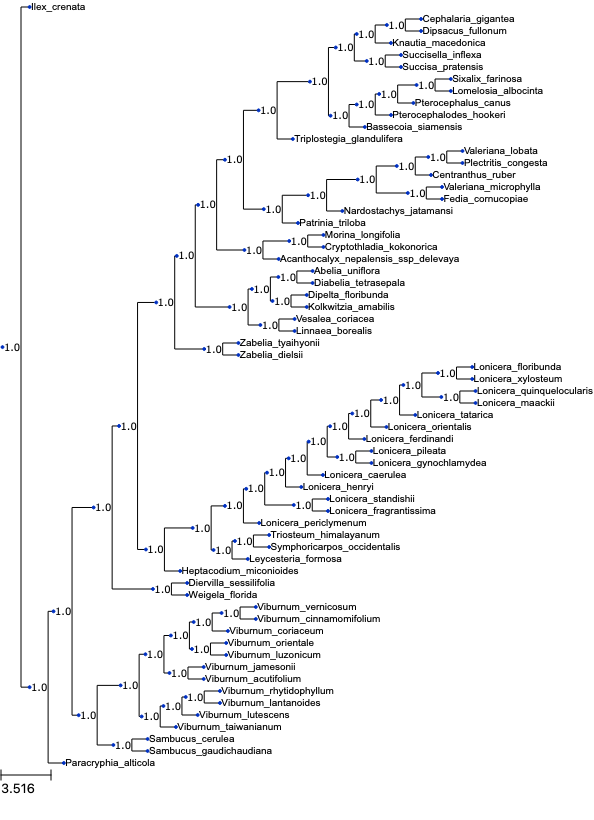

In [4]:
with open(supercontig_st, "r") as s: supercontigTree = Tree(s.readline())
with open(exon_st, "r") as s: exonTree = Tree(s.readline())
bs = TreeStyle()

def bootstrap_fn(mynode):
    if not mynode.is_leaf():
        F = TextFace(str(mynode.support))
        faces.add_face_to_node(F,mynode,0,"branch-top")
        
bs.layout_fn = bootstrap_fn
bs.mode="r"
bs.show_leaf_name = True        

supercontigTree.render("%%inline", tree_style=bs)
# exonTree.render("%%inline", tree_style=bs)

### Identifying common nodes

In [5]:
SCphyparts_node_key = [line for line in open(SCkeyfile)]
SCsubtrees_dict = {n.split()[0]:Tree(n.split()[1]+";") for n in SCphyparts_node_key}
SCsubtrees_topids = {}
for x in SCsubtrees_dict:
    SCsubtrees_topids[x] = SCsubtrees_dict[x].get_topology_id()

for node in supercontigTree.traverse():
    node_topid = node.get_topology_id()
    for subtree in SCsubtrees_dict:
        if node_topid == SCsubtrees_topids[subtree]:
            node.name = subtree
            
EXphyparts_node_key = [line for line in open(EXkeyfile)]
EXsubtrees_dict = {n.split()[0]:Tree(n.split()[1]+";") for n in EXphyparts_node_key}
EXsubtrees_topids = {}
for x in EXsubtrees_dict:
    EXsubtrees_topids[x] = EXsubtrees_dict[x].get_topology_id()

for node in exonTree.traverse():
    node_topid = node.get_topology_id()
    for subtree in EXsubtrees_dict:
        if node_topid == EXsubtrees_topids[subtree]:
            node.name = subtree

### Extracting concordance info

In [6]:
with open(SCconconfile) as phyparts_trees:
    SCconcon_tree = Tree(phyparts_trees.readline())
    SCconflict_tree = Tree(phyparts_trees.readline())

SCconcord_dict = {}
SCconflict_dict = {}

for i, node in enumerate(SCconcon_tree.traverse()):
    node_topid = node.get_topology_id()
    for j, subtree in enumerate(SCsubtrees_dict):
        if node_topid == SCsubtrees_topids[subtree]:
            SCconcord_dict[subtree] = node.support
            
for i, node in enumerate(SCconflict_tree.traverse()):
    node_topid = node.get_topology_id()
    for j, subtree in enumerate(SCsubtrees_dict):
        if node_topid == SCsubtrees_topids[subtree]:
            SCconflict_dict[subtree] = node.support

In [7]:
with open(EXconconfile) as phyparts_trees:
    EXconcon_tree = Tree(phyparts_trees.readline())
    EXconflict_tree = Tree(phyparts_trees.readline())

EXconcord_dict = {}
EXconflict_dict = {}

for i, node in enumerate(EXconcon_tree.traverse()):
    node_topid = node.get_topology_id()
    for j, subtree in enumerate(EXsubtrees_dict):
        if node_topid == EXsubtrees_topids[subtree]:
            EXconcord_dict[subtree] = node.support
            
for i, node in enumerate(EXconflict_tree.traverse()):
    node_topid = node.get_topology_id()
    for j, subtree in enumerate(EXsubtrees_dict):
        if node_topid == EXsubtrees_topids[subtree]:
            EXconflict_dict[subtree] = node.support

### Plotting node numbers

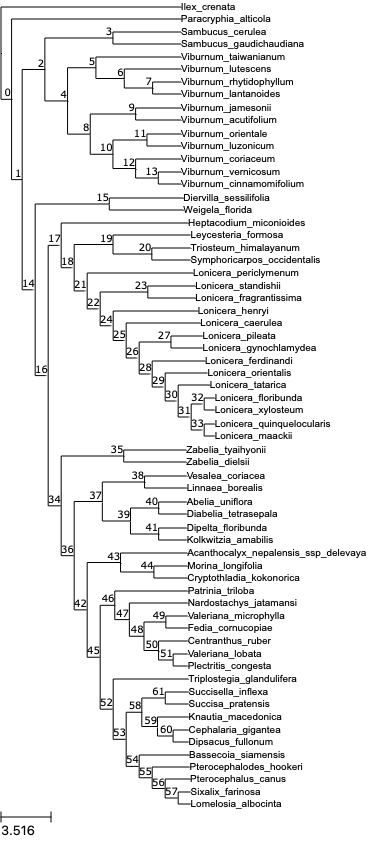

In [8]:
SCnode_tree = supercontigTree.copy()
SCnode_tree.set_outgroup("Ilex_crenata")
SCnode_tree.ladderize()

EXnode_tree = exonTree.copy()
EXnode_tree.set_outgroup("Ilex_crenata")
EXnode_tree.ladderize()

nstyle = NodeStyle()
nstyle["size"] = 0
for n in SCnode_tree.traverse():
    n.set_style(nstyle)
for n in EXnode_tree.traverse():
    n.set_style(nstyle)

SCnode_tree.convert_to_ultrametric()  #Makes the tips sorta line up...  
EXnode_tree.convert_to_ultrametric()
ns = TreeStyle()

def node_name(node):
    if not node.is_leaf():
        F = TextFace(node.name)
        faces.add_face_to_node(face=F, node=node, column=0, position="branch-top")
        
ns.layout_fn = node_name
ns.mode="r"
ns.show_leaf_name = True        

# EXnode_tree.render("%%inline",tree_style=ns)
SCnode_tree.render("%%inline",tree_style=ns)

### Creating pie charts

In [9]:
SCphyparts_hist = [line for line in open(SChistfile)]
SCphyparts_pies = {}
SCphyparts_dict = {}

SCtotal_genes = 308
for n in SCphyparts_hist:
    n = n.split(",")
    tot_genes = float(n.pop(-1))
    node_name = n.pop(0)[4:]
    concord = float(n.pop(0))
    concord = SCconcord_dict[node_name]
    all_conflict = SCconflict_dict[node_name]
    
    if len(n) > 0:   
        most_conflict = max([float(x) for x in n])
    else:
        most_conflict = 0.0
    
    adj_concord = (concord/SCtotal_genes) * 100 
    adj_most_conflict = (most_conflict/SCtotal_genes) * 100
    other_conflict = (all_conflict - most_conflict) / SCtotal_genes * 100
    the_rest = (SCtotal_genes - concord - all_conflict) / SCtotal_genes * 100
    
    pie_list = [adj_concord,adj_most_conflict,other_conflict,the_rest]
    SCphyparts_pies[node_name] = pie_list
    SCphyparts_dict[node_name] = [int(round(concord,0)),int(round(SCtotal_genes-concord,0))]

In [10]:
EXphyparts_hist = [line for line in open(EXhistfile)]
EXphyparts_pies = {}
EXphyparts_dict = {}

EXtotal_genes = 313
for n in EXphyparts_hist:
    n = n.split(",")
    tot_genes = float(n.pop(-1))
    node_name = n.pop(0)[4:]
    concord = float(n.pop(0))
    concord = EXconcord_dict[node_name]
    all_conflict = EXconflict_dict[node_name]
    
    if len(n) > 0:   
        most_conflict = max([float(x) for x in n])
    else:
        most_conflict = 0.0
    
    adj_concord = (concord/EXtotal_genes) * 100 
    adj_most_conflict = (most_conflict/EXtotal_genes) * 100
    other_conflict = (all_conflict - most_conflict) / EXtotal_genes * 100
    the_rest = (EXtotal_genes - concord - all_conflict) / EXtotal_genes * 100
    
    pie_list = [adj_concord,adj_most_conflict,other_conflict,the_rest]
    EXphyparts_pies[node_name] = pie_list
    EXphyparts_dict[node_name] = [int(round(concord,0)),int(round(EXtotal_genes-concord,0))]

### Visualizing pie charts

In [11]:
def SCphyparts_pie_layout(mynode):
    if mynode.name in SCphyparts_pies:
        pie= faces.PieChartFace(SCphyparts_pies[mynode.name],
                              colors = [mcolors.rgb2hex("xkcd:bluish"),
                                        mcolors.rgb2hex("xkcd:amber"),
                                        mcolors.rgb2hex("xkcd:grey"),
                                        mcolors.rgb2hex("xkcd:light gray")],
                              width=50, height=50)
        pie.border.width = None
        pie.opacity = 1.0
        faces.add_face_to_node(pie,mynode, 0, position="branch-right")
        
        concord_text = faces.TextFace(str(int(SCconcord_dict[mynode.name]))+'   ',fsize=20)
        conflict_text = faces.TextFace(str(int(SCconflict_dict[mynode.name]))+'   ',fsize=20)
        
        faces.add_face_to_node(concord_text,mynode,0,position = "branch-top")
        faces.add_face_to_node(conflict_text,mynode,0,position="branch-bottom")
        
        
    else:
        F = faces.TextFace(mynode.name,fsize=20)
        faces.add_face_to_node(F,mynode,0,position="aligned")

def EXphyparts_pie_layout(mynode):
    if mynode.name in EXphyparts_pies:
        pie= faces.PieChartFace(EXphyparts_pies[mynode.name],
                              colors = [mcolors.rgb2hex("xkcd:bluish"),
                                        mcolors.rgb2hex("xkcd:amber"),
                                        mcolors.rgb2hex("xkcd:grey"),
                                        mcolors.rgb2hex("xkcd:light gray")],
                              width=50, height=50)
        pie.border.width = None
        pie.opacity = 1.0
        faces.add_face_to_node(pie,mynode, 0, position="branch-right")
        
        concord_text = faces.TextFace(str(int(EXconcord_dict[mynode.name]))+'   ',fsize=20)
        conflict_text = faces.TextFace(str(int(EXconflict_dict[mynode.name]))+'   ',fsize=20)
        
        faces.add_face_to_node(concord_text,mynode,0,position = "branch-top")
        faces.add_face_to_node(conflict_text,mynode,0,position="branch-bottom")
        
        
    else:
        F = faces.TextFace(mynode.name,fsize=20)
        faces.add_face_to_node(F,mynode,0,position="aligned")

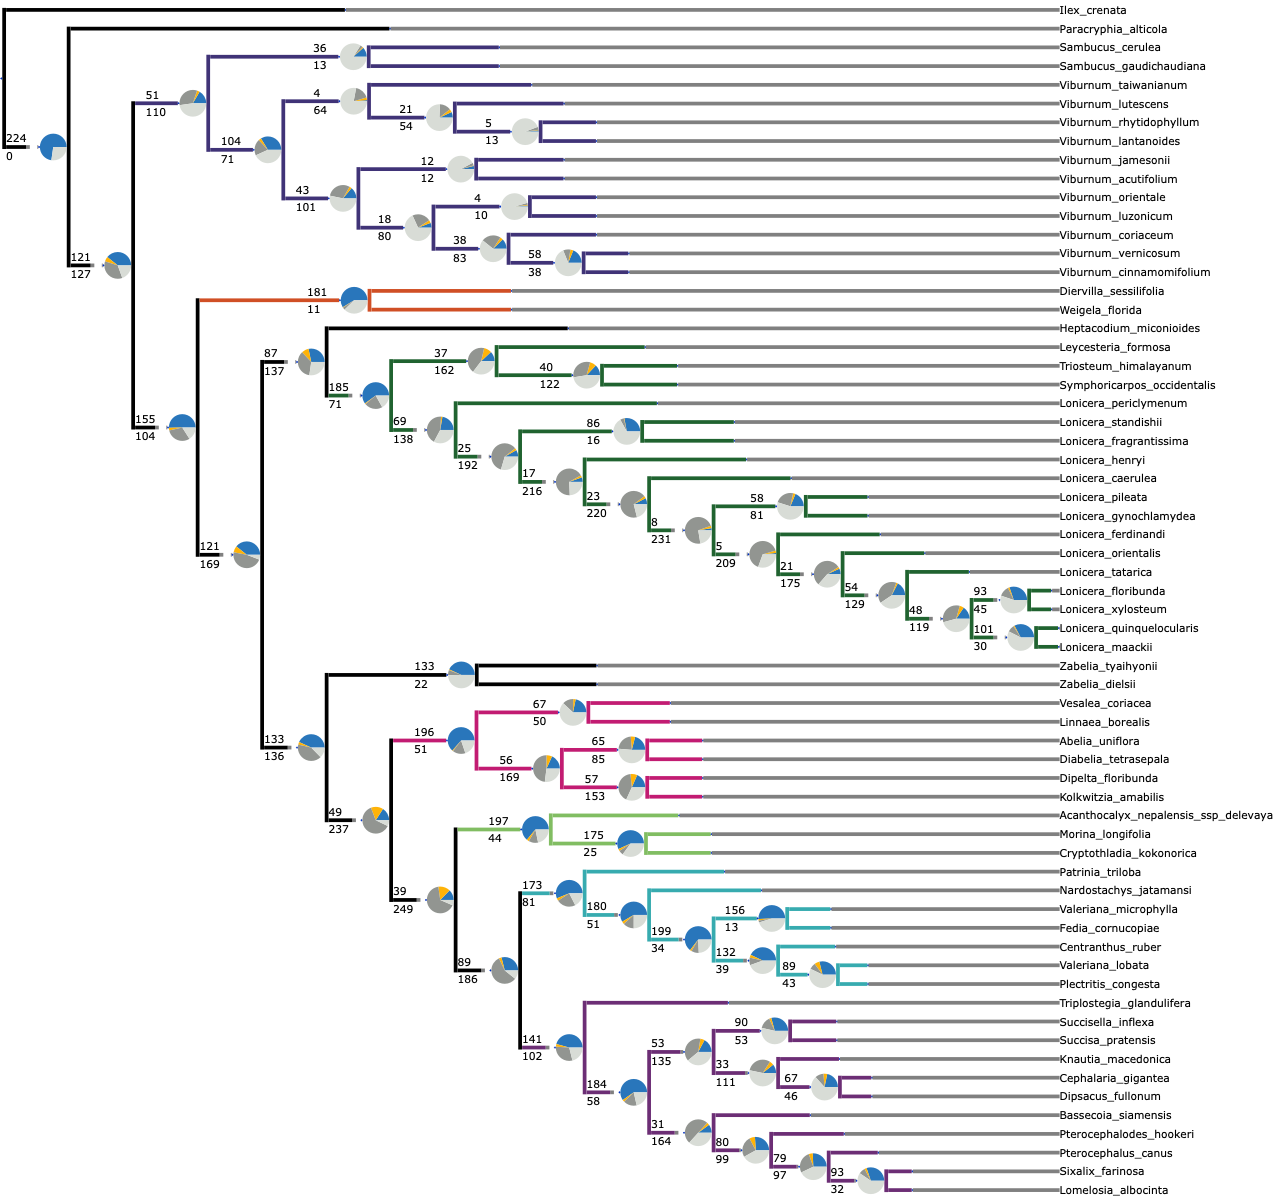

In [12]:
plot_tree = supercontigTree.copy()
plot_tree.set_outgroup("Ilex_crenata")
plot_tree.ladderize()

ts = TreeStyle()
ts.show_leaf_name = False
        
ts.layout_fn = SCphyparts_pie_layout

adoxaceae_style = NodeStyle()
adoxaceae_style["vt_line_color"] = mcolors.rgb2hex([64/255,51/255,119/255])
adoxaceae_style["hz_line_color"] = mcolors.rgb2hex([64/255,51/255,119/255])

caprifolioideae_style = NodeStyle()
caprifolioideae_style["vt_line_color"] = mcolors.rgb2hex([32/255,99/255,48/255])
caprifolioideae_style["hz_line_color"] = mcolors.rgb2hex([32/255,99/255,48/255])

diervillioideae_style = NodeStyle()
diervillioideae_style["vt_line_color"] = mcolors.rgb2hex([208/255,79/255,37/255])
diervillioideae_style["hz_line_color"] = mcolors.rgb2hex([208/255,79/255,37/255])

morinaceae_style = NodeStyle()
morinaceae_style["vt_line_color"] = mcolors.rgb2hex([129/255,189/255,98/255])
morinaceae_style["hz_line_color"] = mcolors.rgb2hex([129/255,189/255,98/255])

linnaeeae_style = NodeStyle()
linnaeeae_style["vt_line_color"] = mcolors.rgb2hex([194/255,28/255,114/255])
linnaeeae_style["hz_line_color"] = mcolors.rgb2hex([194/255,28/255,114/255])

valerianaceae_style = NodeStyle()
valerianaceae_style["vt_line_color"] = mcolors.rgb2hex([55/255,171/255,175/255])
valerianaceae_style["hz_line_color"] = mcolors.rgb2hex([55/255,171/255,175/255])

dipsacaceae_style = NodeStyle()
dipsacaceae_style["vt_line_color"] = mcolors.rgb2hex([108/255,46/255,117/255])
dipsacaceae_style["hz_line_color"] = mcolors.rgb2hex([108/255,46/255,117/255])

for n in plot_tree.traverse():    
    if n == plot_tree.get_common_ancestor("Sambucus_gaudichaudiana", "Viburnum_jamesonii"):
        for d in n.traverse(): d.set_style(adoxaceae_style)
    elif n == plot_tree.get_common_ancestor("Triosteum_himalayanum", "Lonicera_pileata"):
        for d in n.traverse(): d.set_style(caprifolioideae_style)
    elif n == plot_tree.get_common_ancestor("Diervilla_sessilifolia", "Weigela_florida"):
        for d in n.traverse(): d.set_style(diervillioideae_style)
    elif n == plot_tree.get_common_ancestor("Acanthocalyx_nepalensis_ssp_delevaya", "Morina_longifolia"):
        for d in n.traverse(): d.set_style(morinaceae_style)
    elif n == plot_tree.get_common_ancestor("Linnaea_borealis", "Abelia_uniflora"):
        for d in n.traverse(): d.set_style(linnaeeae_style)
    elif n == plot_tree.get_common_ancestor("Patrinia_triloba", "Valeriana_lobata"):
        for d in n.traverse(): d.set_style(valerianaceae_style)
    elif n == plot_tree.get_common_ancestor("Dipsacus_fullonum", "Triplostegia_glandulifera"):
        for d in n.traverse(): d.set_style(dipsacaceae_style)
            
    n.img_style["vt_line_width"] = 7.5
    n.img_style["hz_line_width"] = 7.5
    
ts.draw_guiding_lines = True
# ts.guiding_lines_color = "black"
ts.guiding_lines_type = 0
ts.scale = 50
ts.branch_vertical_margin = 10
ts.show_scale = False
plot_tree.convert_to_ultrametric()
plot_tree.render("%%inline", tree_style=ts, units="in", h=12.5, dpi=96)

## Testing for differnces in concordance datasets
Below I'll do a few tests to see if there are differences between the number of gene trees, concordance, etc. between the supercontig and exon-only data.

In [13]:
def medianIQR(l):
    return(np.percentile(l, 25),np.median(l),np.percentile(l, 75))

def normal_test(x, alpha, log=False):   
    if log:
        x = np.log(x)
    k2, p = stats.normaltest(x)
    print("p = {:g}".format(p))
    if p < alpha:
         print("The null hypothesis can be rejected. Data are not-normal.")
    else:
         print("The null hypothesis cannot be rejected. Data are normal.")
    return k2, p

In [14]:
print(medianIQR([SCconcord_dict[str(n)] for n in np.arange(0,62)]))
print(medianIQR([SCconflict_dict[str(n)] for n in np.arange(0,62)]))
print(medianIQR([SCconcord_dict[str(n)]+SCconflict_dict[(str(n))] for n in np.arange(0,62)]))

(37.25, 67.0, 129.25)
(43.25, 82.0, 136.75)
(138.25, 185.5, 233.0)


In [15]:
print(medianIQR([EXconcord_dict[str(n)] for n in np.arange(0,62)]))
print(medianIQR([EXconflict_dict[str(n)] for n in np.arange(0,62)]))
print(medianIQR([EXconcord_dict[str(n)]+EXconflict_dict[(str(n))] for n in np.arange(0,62)]))

(22.25, 47.0, 105.25)
(58.0, 94.0, 151.25)
(125.0, 183.0, 223.75)


In [16]:
normal_test([SCconcord_dict[str(n)] for n in np.arange(0,62)], alpha=0.01)
normal_test([SCconflict_dict[(str(n))] for n in np.arange(0,62)], alpha=0.01)
normal_test([SCconcord_dict[str(n)]+SCconflict_dict[(str(n))] for n in np.arange(0,62)], alpha=0.01)

p = 0.0374962
The null hypothesis cannot be rejected. Data are normal.
p = 0.0748706
The null hypothesis cannot be rejected. Data are normal.
p = 0.188979
The null hypothesis cannot be rejected. Data are normal.


(3.332238856259523, 0.18897899113256528)

In [17]:
normal_test([EXconcord_dict[str(n)] for n in np.arange(0,62)], alpha=0.01)
normal_test([EXconflict_dict[(str(n))] for n in np.arange(0,62)], alpha=0.01)
normal_test([EXconcord_dict[str(n)]+EXconflict_dict[(str(n))] for n in np.arange(0,62)], alpha=0.01)

p = 0.00779149
The null hypothesis can be rejected. Data are not-normal.
p = 0.0454271
The null hypothesis cannot be rejected. Data are normal.
p = 0.19411
The null hypothesis cannot be rejected. Data are normal.


(3.2786649408301427, 0.19410957293596584)

In [18]:
stats.ttest_ind([SCconcord_dict[str(n)]+SCconflict_dict[(str(n))] for n in np.arange(0,62)],
                [EXconcord_dict[str(n)]+EXconflict_dict[(str(n))] for n in np.arange(0,62)])

Ttest_indResult(statistic=0.452847552672553, pvalue=0.6514628258305055)

In [19]:
stats.ttest_ind([SCconcord_dict[str(n)] for n in np.arange(0,62)],
                [EXconcord_dict[str(n)] for n in np.arange(0,62)])

Ttest_indResult(statistic=1.5058004123353892, pvalue=0.13470320255679566)

In [20]:
stats.ttest_ind([SCconflict_dict[(str(n))] for n in np.arange(0,62)],
                [EXconflict_dict[(str(n))] for n in np.arange(0,62)])

Ttest_indResult(statistic=-0.9535713505954736, pvalue=0.3421861899295816)

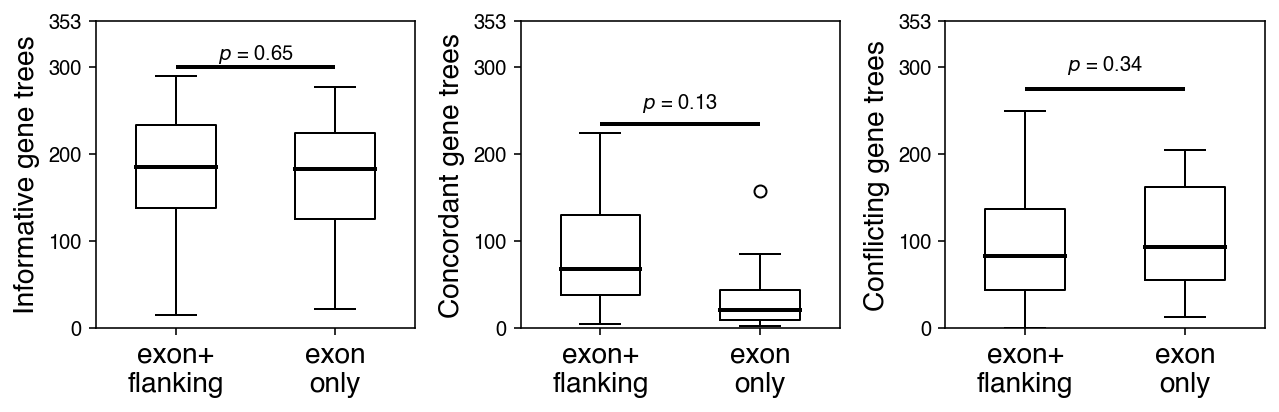

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(9,3))

ax[0].boxplot([[SCconcord_dict[str(n)]+SCconflict_dict[str(n)] for n in np.arange(0,62)],
               [EXconcord_dict[str(n)]+EXconflict_dict[str(n)] for n in np.arange(0,62)]], 
              widths=0.5, medianprops=dict(color="xkcd:black", linewidth=2))
ax[0].hlines(xmin=1, xmax=2, y=300, linewidth=2)
ax[0].text(x=1.5, y = 300*1.05, s="$p$ = 0.65", ha='center', va='center')
ax[0].set_ylim(0,353)
ax[0].set_ylabel("Informative gene trees", size=14)

ax[1].boxplot([[SCconcord_dict[str(n)] for n in np.arange(0,62)],[EXconcord_dict[str(n)] for n in np.arange(34,62)]],
              widths=0.5, medianprops=dict(color="xkcd:black", linewidth=2))
ax[1].hlines(xmin=1, xmax=2, y=235, linewidth=2)
ax[1].text(x=1.5, y = 235*1.1, s="$p$ = 0.13", ha='center', va='center')
ax[1].set_ylim(0,353)
ax[1].set_ylabel("Concordant gene trees", size=14)

ax[2].boxplot([[SCconflict_dict[str(n)] for n in np.arange(0,62)],[EXconflict_dict[str(n)] for n in np.arange(34,62)]],
              widths=0.5, medianprops=dict(color="xkcd:black", linewidth=2))
ax[2].hlines(xmin=1, xmax=2, y=275, linewidth=2)
ax[2].text(x=1.5, y = 275*1.1, s="$p$ = 0.34", ha='center', va='center')
ax[2].set_ylim(0,353)
ax[2].set_ylabel("Conflicting gene trees", size=14)

for i in range(3):
    ax[i].set_xticks(range(1,3))
    ax[i].set_xticklabels(["exon+\nflanking","exon\nonly"], size=14)
    ax[i].set_yticks([0,100,200,300,353])
    ax[i].set_yticklabels([0,100,200,300,353])
        
plt.tight_layout()

## Support for _Heptacodium_ alternate placement

In [22]:
with open(supercontig_st, "r") as f:
    supercontigTree = toytree.tree(f.readline())
    
with open(exon_st, "r") as f:
    exonTree = toytree.tree(f.readline())

In [23]:
caprifolieae_node = supercontigTree.get_mrca_idx_from_tip_labels(["Leycesteria_formosa", "Lonicera_maackii"])
caprifolieae_taxa = supercontigTree.get_tip_labels(idx=caprifolieae_node)
linnaeeae_node = supercontigTree.get_mrca_idx_from_tip_labels(["Linnaea_borealis", "Abelia_uniflora"])
linnaeeae_taxa = supercontigTree.get_tip_labels(idx=linnaeeae_node)
linnina_node = supercontigTree.get_mrca_idx_from_tip_labels(["Zabelia_dielsii", "Sixalix_farinosa"])
linnina_taxa = supercontigTree.get_tip_labels(idx=linnina_node)
morinaceae_node = supercontigTree.get_mrca_idx_from_tip_labels(["Morina_longifolia", "Acanthocalyx_nepalensis_ssp_delevaya"])
morinaceae_taxa = supercontigTree.get_tip_labels(idx=morinaceae_node)
zabelia_taxa = ["Zabelia_tyaihyoni", "Zabelia_dielsii"]
valerianaceae_node = supercontigTree.get_mrca_idx_from_tip_labels(["Patrinia_triloba", "Valeriana_lobata"])
valerianaceae_taxa = supercontigTree.get_tip_labels(idx=valerianaceae_node)
dipsacoideae_node = supercontigTree.get_mrca_idx_from_tip_labels(["Triplostegia_glandulifera", "Sixalix_farinosa"])
dipsacoideae_taxa = supercontigTree.get_tip_labels(idx=dipsacoideae_node)

Now what I'll do is extract all of the gene trees that have 
1. _Heptacodium_
2. At least one member of Caprifolieae
3. At least one member of Linnina

In [24]:
hept_testable = []
with open(supercontig_gts, "r") as f:
    for line in f.readlines():
        if ("Heptacodium_miconioides" in line) and \
            any([cap in line for cap in caprifolieae_taxa]) and \
            any([lin in line for lin in linnina_taxa]):
            hept_testable.append(line)
print(len(hept_testable))

208


In [25]:
# Unambiguously support
hept_cap = 0
hept_lin = 0
# Completely ambiguous
hept_ambig = 0

for gt in [toytree.tree(newick) for newick in hept_testable]:
    hept_idx = gt.get_mrca_idx_from_tip_labels("Heptacodium_miconioides")
    hept_node = [node for node in gt.treenode.traverse("levelorder") if node.idx==hept_idx][0]
    sister_taxa = hept_node.get_sisters()[0].get_leaf_names()
    sister_caps = list(set(caprifolieae_taxa).intersection(set(sister_taxa)))
    sister_lins = list(set(linnina_taxa).intersection(set(sister_taxa)))
    
    if len(sister_caps) > 0 and len(sister_lins)==0:
            hept_cap+=1
    elif len(sister_lins) > 0 and len(sister_caps)==0:
            hept_lin+=1
    else:
        hept_ambig+=1

print("{} gene trees".format(len(hept_testable)))
print("Support (Heptacodium, Caprifolioideae): {} ({:.2})".format(hept_cap, hept_cap/len(hept_testable)))
print("Support (Heptacodium, Linnina): {} ({:.2})".format(hept_lin, hept_lin/len(hept_testable)))
print("Ambiguous: {} ({:.2})".format(hept_ambig, hept_ambig/len(hept_testable)))

208 gene trees
Support (Heptacodium, Caprifolioideae): 114 (0.55)
Support (Heptacodium, Linnina): 38 (0.18)
Ambiguous: 56 (0.27)


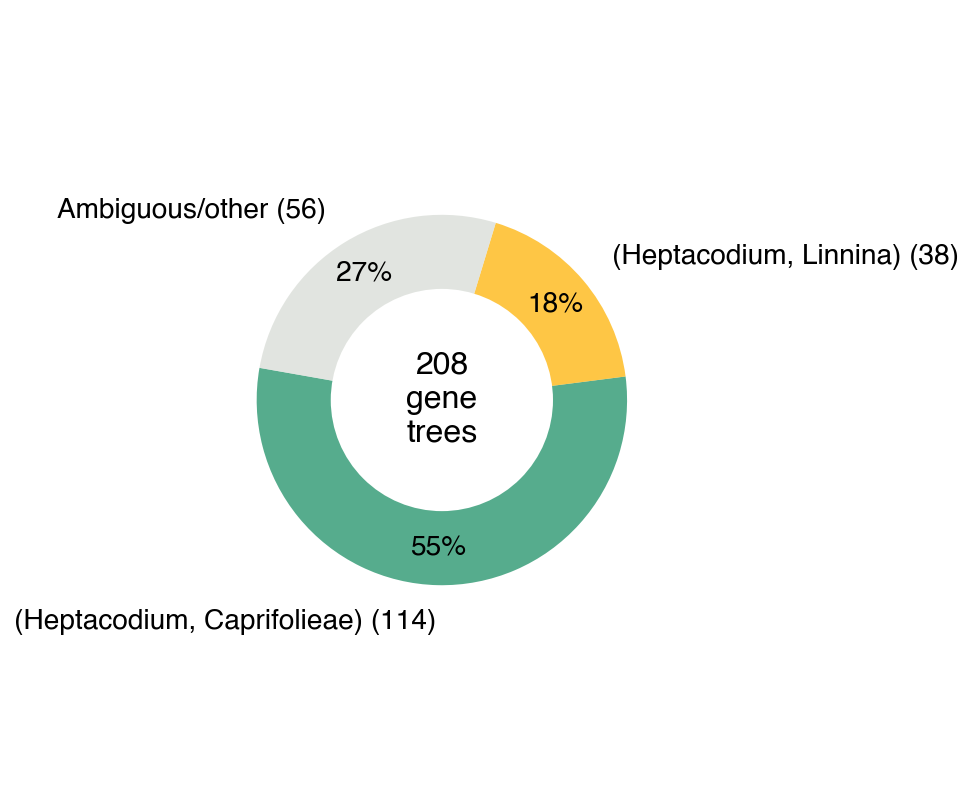

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# First pie
sizes = [hept_cap, hept_lin, len(hept_testable)-hept_cap-hept_lin]
labels=["(Heptacodium, Caprifolieae) ({})".format(sizes[0]),
        "(Heptacodium, Linnina) ({})".format(sizes[1]),
        "Ambiguous/other ({})".format(sizes[2])]

colors = ["xkcd:viridian","xkcd:amber", "xkcd:light grey"]

patches, texts, autotexts = ax.pie(sizes, startangle=170, labels=labels, colors=colors, 
                                      autopct='%1.f%%', pctdistance=0.8, labeldistance=1.2)

# Edit patches and text
for p in patches:
    p.set_alpha(0.75)
for i, t in enumerate(autotexts):
    t.set_size(14)
    texts[i].set_size(14)
# Add center cirle with text
centre_circle0 = plt.Circle((0,0), 0.6, color='black', fc='white',linewidth=0)
ax.add_artist(centre_circle0)
ax.text(x=0, y=0, s="{}\ngene\ntrees".format(len(hept_testable)), 
           horizontalalignment='center', verticalalignment='center', size=16)
ax.axis('equal')

plt.tight_layout()

So, despite the large red slice of the pie chart at the node that includes *Heptacodium*, Caprifolieae, and Linnina, most gene trees support the relationship (*Heptacodium*, Caprifolieae).